<a href="https://colab.research.google.com/github/danplotkin/Fine-Tune-DistilBERT-for-Text-Classification/blob/main/symptom2disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Requirements

In [1]:
!pip install opendatasets

In [2]:
!pip install accelerate -U

In [3]:
!pip install transformers

In [4]:
!pip install evaluate

In [5]:
import pandas as pd
import numpy as np
import os
import random
from datasets import Dataset
import opendatasets as od
import matplotlib.pyplot as plt

import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    pipeline
)
import evaluate

plt.style.use('seaborn-v0_8')

# Download Dataset

In [6]:
od.download('https://www.kaggle.com/datasets/niyarrbarman/symptom2disease')

Skipping, found downloaded files in "./symptom2disease" (use force=True to force download)


# Define Parameters

In [7]:
DIRECTORY = '/content/symptom2disease/Symptom2Disease.csv'
MODEL_NAME = 'distilbert-base-uncased'
BATCH_SIZE = 32
LR = 2e-5
EPOCHS = 25
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Import Data

In [8]:
# load in df
df = pd.read_csv(DIRECTORY)

# preview df
df.head()

,Unnamed: 0,label,text
0,0,Psoriasis,I have been experiencing a skin rash on my arm...
1,1,Psoriasis,"My skin has been peeling, especially on my kne..."
2,2,Psoriasis,I have been experiencing joint pain in my fing...
3,3,Psoriasis,"There is a silver like dusting on my skin, esp..."
4,4,Psoriasis,"My nails have small dents or pits in them, and..."


Let us remove columns of no use.

In [9]:
df = df.drop(list(df.columns)[0], axis=1)

In [10]:
# reorder dataframe columns
df = df[['text', 'label']]

# view shape
df.shape

(1200, 2)

# Basic EDA

In [11]:
# view number of classes
n_classes = df['label'].nunique()
print(f"Number of disease classes: {n_classes}")

Number of disease classes: 24


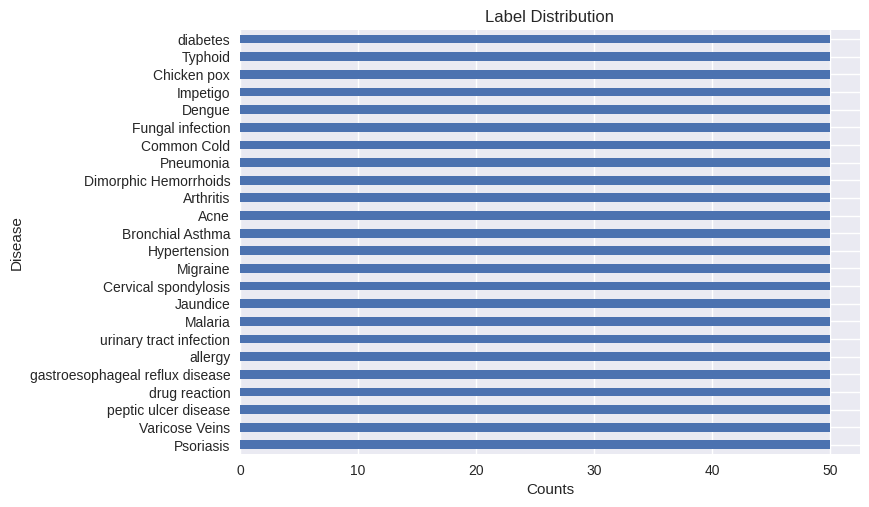

In [12]:
# view the label distribution in the dataset
df['label'].value_counts().plot(kind='barh')
plt.title('Label Distribution')
plt.ylabel('Disease')
plt.xlabel('Counts')
plt.show()

In [13]:
# view some statistics about are texts
lengths = df['text'].apply(lambda x: len(x))
print(
    f'Max text length: {lengths.max()}\nMin text length: {lengths.min()}\nAvg text length: {lengths.mean():.2f}'
)

Max text length: 317
Min text length: 60
Avg text length: 171.88


# Preprocess Dataset

We will first create a mapping of ids to our labels. This will be used for two things:

1. We will use a label-to-id mapping to label encode our labels.
2. We need will feed our model a id-to-label and label-to-id dictionary mapping so our model can decode our labels during training and evaluation

In [14]:
# create mappings
id2label = {idx: label for idx, label in enumerate(df['label'].unique())}
label2id = {label: idx for idx, label in id2label.items()}

In [15]:
# label encode our labels
df['label'] = df['label'].map(label2id)

Now we will use the `from_pandas()` method from the `Dataset` class to create a dataset dictionary, and then use the `train_test_split()` method to split our data into training and validation sets.

In [16]:
# create and split dataset
dataset = Dataset.from_pandas(df).train_test_split(train_size=0.8)
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 960
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 240
    })
})


### Tokenize Text

We wil now tokenize our text using the tokenizer from the DistilBERT model.

In [17]:
# initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [18]:
# Tokenize and encode the dataset
def tokenize(batch):
    tokenized_batch = tokenizer(batch['text'], truncation=True)
    return tokenized_batch

dataset_enc = dataset.map(tokenize, batched=True)

Map:   0%|          | 0/960 [00:00<?, ? examples/s]

Map:   0%|          | 0/240 [00:00<?, ? examples/s]

In [19]:
print(dataset_enc)

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 960
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 240
    })
})


# Train

### Define Metrics

We need to define our model's accuracy function. Since this is a classification task, we will use the `argmax()` method from `numpy`.

In [20]:
accuracy = evaluate.load('accuracy')

In [21]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

### Define Model Params

In [22]:
# define model
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=n_classes,
    id2label=id2label,
    label2id=label2id
)

# configure model to device
model.to(DEVICE)

# define collator function
collator_fn = DataCollatorWithPadding(tokenizer, return_tensors='pt')

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Train Model

Below we will use the `Trainer` API to fine-tune DistilBERT onto our data. We will define a training arguments object that will define our training details and hyperparameters. This will be an input into the final trainer object that will then be used for training and evaluation.

In [23]:
training_args = TrainingArguments(
    output_dir="Symptom2Disease_training",
    learning_rate=LR,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    logging_strategy='epoch'
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_enc["train"],
    eval_dataset=dataset_enc["test"],
    tokenizer=tokenizer,
    data_collator=collator_fn,
    compute_metrics=compute_metrics
)

trainer.train()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,3.109300,2.925709,0.500000
2,2.705000,2.411101,0.704167
3,2.200100,1.936232,0.795833
4,1.747500,1.532132,0.858333
5,1.364100,1.190525,0.933333
6,1.043100,0.918143,0.945833
7,0.786200,0.710999,0.975000
8,0.591900,0.539276,0.975000
9,0.442700,0.419314,0.970833
10,0.319600,0.321699,0.983333


TrainOutput(global_step=750, training_loss=0.6226406860351562, metrics={'train_runtime': 235.9446, 'train_samples_per_second': 101.719, 'train_steps_per_second': 3.179, 'total_flos': 398378075862528.0, 'train_loss': 0.6226406860351562, 'epoch': 25.0})

In [24]:
trainer.save_model('Symptom-2-disease_distilBERT')

# Evaluate on Validation Data

In [25]:
trainer.evaluate()

{'eval_loss': 0.09832779318094254,
 'eval_accuracy': 0.9833333333333333,
 'eval_runtime': 0.6463,
 'eval_samples_per_second': 371.332,
 'eval_steps_per_second': 12.378,
 'epoch': 25.0}

# Make Predictions

We will create a classifier with our fine-tuned model with the `pipeline` function. We will then make prediction on a random sample in our validation set and validate that it is correct.

In [32]:
model = AutoModelForSequenceClassification.from_pretrained('Symptom-2-disease_distilBERT')

In [34]:
# Create a pipeline object for sequence classification
classifier = pipeline(
    'text-classification',
    model=model,
    tokenizer=tokenizer
)

In [35]:
def map_id_to_text(idx):
    """
    Function to get the label when given its corresponding label encoded value.
    """
    return id2label[idx]


def get_random_sample():
    """
    Function to get a random sample from the testing dataset.
    """
    data = dataset['test'][np.random.randint(0, 100)]
    text = data['text']
    truth = map_id_to_text(data['label'])
    return {'text': text, 'truth': truth}


def predict(sample):
    """
    Function to predict the disease when given a random sample.

    Args:
    `sample` (dict): Random sample.
    `validate` (bool): If True, will return a boolean value indicating if the predicted label is correct.
    """
    pred = classifier(sample['text'])[0]['label']
    truth = sample['truth']
    return pred

Below we will predict 5 random samples.

In [42]:
for _ in range(5):
    sample = get_random_sample()
    print(f"Text: {sample['text']}")
    print(f"PREDICTED: {predict(sample)}, TRUTH: {sample['truth']}")
    print('\n'*2)

Text: I've been feeling sick and feel a strong need to vomit. There is a sharp ache behind my eyes, and swollen red dots all over my back.
PREDICTED: Dengue, TRUTH: Dengue



Text: I've been experiencing problems using the restroom recently. It's quite difficult for me to go, and it hurts when I do. I've also been experiencing buttock soreness and bloody stools. My anus has also been quite itching and sensitive.
PREDICTED: Dimorphic Hemorrhoids, TRUTH: Dimorphic Hemorrhoids



Text: I've had a pretty uncomfortable itch all over my body, as well as red and bumpy areas on my skin. There are also certain patches of my skin that are a different hue than the rest of it, and I've had some pimples that resemble little balls.
PREDICTED: Fungal infection, TRUTH: Fungal infection



Text: I've been feeling really weak and cold lately, and this cough won't go away. It hurts in my chest when I cough, and my heart is pounding. The mucus I'm bringing up is a rusty brown color.
PREDICTED: Pneumonia, 